In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import os
import warnings
import glob

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 6)
pd.set_option("display.max_rows", 6)
np.random.seed(2)

## Load the data and process it

In [4]:
dataset_path = "dataset/"

def load_all_scenes():
    scene_ids = [file.split("/")[-1].split(".")[0] for file in glob.glob(f"{dataset_path}*.nodes")]
    all_scenes = []
    for scene_id in scene_ids:
        edges_file = os.path.join(dataset_path, f"{scene_id}.edges")
        nodes_file = os.path.join(dataset_path, f"{scene_id}.nodes")

        edges_df = pd.read_csv(edges_file, header=None, names=["target", "source"], na_values="_")
        nodes_df = pd.read_csv(
            nodes_file,
            header=None,
            names=["node_id", "current_x", "current_y", "previous_x", "previous_y", "future_x", "future_y"],
            na_values="_"
        )

        if nodes_df.isnull().any().any():
            nan_nodes = nodes_df[nodes_df.isnull().any(axis=1)]
            nan_node_ids = nan_nodes["node_id"].tolist()
            edges_df = edges_df[~edges_df["source"].isin(nan_node_ids) & ~edges_df["target"].isin(nan_node_ids)]
            nodes_df = nodes_df.dropna(subset=["future_x", "future_y"])

        if (edges_df["source"] == -1).any() or (edges_df["target"] == -1).any():
            edges_df = edges_df[(edges_df["source"] != -1) & (edges_df["target"] != -1)]
            connected_nodes = pd.unique(edges_df[["target", "source"]].values.ravel())
            nodes_df = nodes_df[nodes_df["node_id"].isin(connected_nodes)]

        nodes_df = nodes_df.replace('_', np.nan)
        edges_df = edges_df.replace('_', np.nan)

        if len(nodes_df) > 0:
            node_id_to_idx = {node_id: idx for idx, node_id in enumerate(nodes_df["node_id"].values)}
            edges_df = edges_df.dropna()
            edges_df['target'] = edges_df['target'].apply(lambda x: node_id_to_idx.get(x, -1))
            edges_df['source'] = edges_df['source'].apply(lambda x: node_id_to_idx.get(x, -1))
            edges_df = edges_df[(edges_df['target'] != -1) & (edges_df['source'] != -1)]

            all_scenes.append({
                "scene_id": scene_id,
                "node_features": tf.convert_to_tensor(
                    nodes_df[["current_x", "current_y", "previous_x", "previous_y"]].values,
                    dtype=tf.float32
                ),
                "labels": tf.convert_to_tensor(nodes_df[["future_x", "future_y"]].values, dtype=tf.float32),
                "edges": tf.convert_to_tensor(edges_df[["target", "source"]].values, dtype=tf.int32),
                "node_indices": np.arange(len(nodes_df)),
            })
            
    return all_scenes


scenes = load_all_scenes()

# Shuffle and split into train, validation, and test sets
np.random.seed(2)
np.random.shuffle(scenes)

""" 70% Training set """
# train_scenes = scenes[:int(0.7 * len(scenes))]
# val_scenes = scenes[int(0.7 * len(scenes)):int(0.9 * len(scenes))]
# test_scenes = scenes[int(0.9 * len(scenes)):]

""" 50% Training set """
train_scenes = scenes[:int(0.5 * len(scenes))]
val_scenes = scenes[int(0.5 * len(scenes)):int(0.9 * len(scenes))]
test_scenes = scenes[int(0.9 * len(scenes)):]

print(f"Total scenes: {len(scenes)}")
print(f"Training scenes: {len(train_scenes)}")
print(f"Validation scenes: {len(val_scenes)}")
print(f"Test scenes: {len(test_scenes)}")

def scene_to_sample(scene):
    return (scene["node_features"], scene["edges"], scene["labels"])

train_samples = [scene_to_sample(scene) for scene in train_scenes]
val_samples = [scene_to_sample(scene) for scene in val_scenes]
test_samples = [scene_to_sample(scene) for scene in test_scenes]

output_signature = (
    tf.TensorSpec(shape=(None, 4), dtype=tf.float32),
    tf.TensorSpec(shape=(None, 2), dtype=tf.int32),
    tf.TensorSpec(shape=(None, 2), dtype=tf.float32),
)

train_dataset = tf.data.Dataset.from_generator(
    lambda: iter(train_samples),
    output_signature=output_signature
)

val_dataset = tf.data.Dataset.from_generator(
    lambda: iter(val_samples),
    output_signature=output_signature
)

test_dataset = tf.data.Dataset.from_generator(
    lambda: iter(test_samples),
    output_signature=output_signature
)

def squeeze_batch(features, edges, targets):
    return tf.squeeze(features, axis=0), tf.squeeze(edges, axis=0), tf.squeeze(targets, axis=0)

train_dataset = train_dataset.shuffle(100).batch(1).map(squeeze_batch)
val_dataset = val_dataset.batch(1).map(squeeze_batch)
test_dataset = test_dataset.batch(1).map(squeeze_batch)


Total scenes: 189
Training scenes: 94
Validation scenes: 76
Test scenes: 19


## GAT model implementation

In [ ]:
class GraphAttention(layers.Layer):
    def __init__(
        self,
        units,
        kernel_initializer="glorot_uniform",
        kernel_regularizer=None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.units = units
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)

    def build(self, input_shape):
        self.kernel = self.add_weight(
            shape=(input_shape[0][-1], self.units),
            trainable=True,
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            name="kernel",
        )
        self.kernel_attention = self.add_weight(
            shape=(self.units * 2, 1),
            trainable=True,
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            name="kernel_attention",
        )
        self.built = True

    def call(self, inputs):
        node_states, edges = inputs

        # Linearly transform node states
        node_states_transformed = tf.matmul(node_states, self.kernel)

        """
        # (1) Compute pair-wise attention scores
        node_states_expanded = tf.gather(node_states_transformed, edges)
        node_states_expanded = tf.reshape(
            node_states_expanded, (tf.shape(edges)[0], -1)
        )
        attention_scores = tf.nn.leaky_relu(
            tf.matmul(node_states_expanded, self.kernel_attention)
        )
        attention_scores = tf.squeeze(attention_scores, -1)
        """

        # Use cosine similarity:
        src = tf.gather(node_states_transformed, edges[:, 0])
        dst = tf.gather(node_states_transformed, edges[:, 1])
        dot_product = tf.reduce_sum(src * dst, axis=1)
        src_norm = tf.norm(src, axis=1)
        dst_norm = tf.norm(dst, axis=1)
        cosine_similarity = dot_product / (src_norm * dst_norm + 1e-8)
        attention_scores = cosine_similarity  # No learnable weights

        # (2) Normalize attention scores
        attention_scores = tf.math.exp(tf.clip_by_value(attention_scores, -2, 2))
        attention_scores_sum = tf.math.unsorted_segment_sum(
            data=attention_scores,
            segment_ids=edges[:, 0],
            num_segments=tf.reduce_max(edges[:, 0]) + 1,
        )
        attention_scores_sum = tf.repeat(
            attention_scores_sum, tf.math.bincount(tf.cast(edges[:, 0], "int32"))
        )
        attention_scores_norm = attention_scores / attention_scores_sum

        # (3) Gather node states of neighbors, apply attention scores and aggregate
        node_states_neighbors = tf.gather(node_states_transformed, edges[:, 1])
        out = tf.math.unsorted_segment_sum(
            data=node_states_neighbors * attention_scores_norm[:, tf.newaxis],
            segment_ids=edges[:, 0],
            num_segments=tf.shape(node_states)[0],
        )
        return out


class MultiHeadGraphAttention(layers.Layer):
    def __init__(self, units, num_heads=8, merge_type="concat", **kwargs):
        super().__init__(**kwargs)
        self.num_heads = num_heads
        self.merge_type = merge_type
        self.attention_layers = [GraphAttention(units) for _ in range(num_heads)]

    def call(self, inputs):
        atom_features, pair_indices = inputs

        # Obtain outputs from each attention head
        outputs = [
            attention_layer([atom_features, pair_indices])
            for attention_layer in self.attention_layers
        ]
        # Concatenate or average the node states from each head
        if self.merge_type == "concat":
            outputs = tf.concat(outputs, axis=-1)
        else:
            outputs = tf.reduce_mean(tf.stack(outputs, axis=-1), axis=-1)
        # Activate and return node states
        return tf.nn.relu(outputs)


class GraphAttentionNetwork(keras.Model):
    def __init__(
        self,
        #node_states,
        #edges,
        hidden_units,
        num_heads,
        num_layers,
        output_dim,
        **kwargs,
    ):
        super().__init__(**kwargs)
        #self.node_states = node_states
        #self.edges = edges
        self.preprocess = keras.Sequential([
            layers.Dense(hidden_units * num_heads, activation="relu"),
            layers.Dense(hidden_units * num_heads, activation="relu"),
            layers.Dense(hidden_units * num_heads, activation=None),
        ])
        self.attention_layers = [
            MultiHeadGraphAttention(hidden_units, num_heads) for _ in range(num_layers)
        ]
        self.output_layer = layers.Dense(output_dim)

    def call(self, inputs):
        node_states, edges = inputs
        x = self.preprocess(node_states)
        for attention_layer in self.attention_layers:
            x = attention_layer([x, edges]) + x
        outputs = self.output_layer(x)
        return outputs

    def train_step(self, data):
        node_features, edges, labels = data  # Unpack the batch
        with tf.GradientTape() as tape:
            outputs = self([node_features, edges], training=True)
            loss = self.compiled_loss(labels, outputs)
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.compiled_metrics.update_state(labels, outputs)
        return {m.name: m.result() for m in self.metrics}

    def predict_step(self, data):
        node_features, edges, _ = data  # labels may not be present
        outputs = self([node_features, edges], training=False)
        return outputs

    def test_step(self, data):
        node_features, edges, labels = data
        outputs = self([node_features, edges], training=False)
        loss = self.compiled_loss(labels, outputs)
        self.compiled_metrics.update_state(labels, outputs)
        return {m.name: m.result() for m in self.metrics}


# Task 1 - adjust the model to the new data

In [ ]:
# Define hyper-parameters
HIDDEN_UNITS = 100
NUM_HEADS = 8
NUM_LAYERS = 3
OUTPUT_DIM = 2

NUM_EPOCHS = 100
LEARNING_RATE = 1e-4

# Build model
gat_model = GraphAttentionNetwork(
    HIDDEN_UNITS, NUM_HEADS, NUM_LAYERS, OUTPUT_DIM
)

callbacks = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Compile model
gat_model.compile(
    loss=keras.losses.MeanAbsoluteError(name="mean_absolute_error"),
    optimizer=keras.optimizers.Adam(
        learning_rate=LEARNING_RATE,
        clipnorm=1.0, 
        epsilon=1e-8
    ),
    metrics=[keras.metrics.MeanAbsoluteError(name="mean_absolute_error")]
)

gat_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=NUM_EPOCHS,
    verbose=2,
    callbacks=callbacks
)

_, test_accuracy = gat_model.evaluate(x=test_dataset, verbose=1)
print(f"Test Mean Absolute Error: {test_accuracy}")


all_predictions = []
all_ground_truth = []
sample_count = 0

print("Evaluating model on entire test dataset")

for features, edges, targets in test_dataset:
    predictions = gat_model((features, edges), training=False)
    
    # Convert to numpy for easier handling
    pred_np = predictions.numpy()
    targets_np = targets.numpy()
    
    # Store predictions
    all_predictions.append(pred_np)
    all_ground_truth.append(targets_np)
    
    sample_count += len(pred_np)

print(f"Processed {len(all_predictions)} scenes with {sample_count} total nodes")

# Concatenate all predictions and ground truth values
all_pred_concat = np.concatenate(all_predictions)
all_gt_concat = np.concatenate(all_ground_truth)

# Calculate MAE for x and y coordinates separately
mae_x = np.mean(np.abs(all_pred_concat[:, 0] - all_gt_concat[:, 0]))
mae_y = np.mean(np.abs(all_pred_concat[:, 1] - all_gt_concat[:, 1]))

# Calculate overall MAE
mae = np.mean(np.abs(all_pred_concat - all_gt_concat))

# Calculate Euclidean distance for each prediction
euclidean_distances = np.sqrt(np.sum((all_pred_concat - all_gt_concat)**2, axis=1))
mean_euclidean = np.mean(euclidean_distances)
median_euclidean = np.median(euclidean_distances)

print("\n===== Evaluation Metrics =====")
print(f"Mean Absolute Error (overall): {mae:.2f}")
print(f"Mean Absolute Error (x-coordinate): {mae_x:.2f}")
print(f"Mean Absolute Error (y-coordinate): {mae_y:.2f}")
print(f"Mean Euclidean Distance: {mean_euclidean:.2f} units")
print(f"Median Euclidean Distance: {median_euclidean:.2f} units")


Epoch 1/100


2025-04-18 13:17:58.710421: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 29s - 304ms/step - mean_absolute_error: 6505.2476 - loss: 2387.4807 - val_loss: 3547.8711
Epoch 2/100


2025-04-18 13:18:02.078240: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-18 13:18:03.099324: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 1s - 14ms/step - mean_absolute_error: 5084.1738 - loss: 3092.0378 - val_loss: 3309.8948
Epoch 3/100


2025-04-18 13:18:03.353656: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-18 13:18:04.384904: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 1s - 14ms/step - mean_absolute_error: 3192.3396 - loss: 3234.3083 - val_loss: 4164.6562
Epoch 4/100


2025-04-18 13:18:04.643345: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-18 13:18:05.692189: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 1s - 14ms/step - mean_absolute_error: 1857.7849 - loss: 4151.8018 - val_loss: 5814.7852
Epoch 5/100


2025-04-18 13:18:05.953199: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-18 13:18:06.979103: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 1s - 14ms/step - mean_absolute_error: 1171.6692 - loss: 5009.2554 - val_loss: 6332.9761
Epoch 6/100


2025-04-18 13:18:07.237131: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-18 13:18:08.256949: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 1s - 14ms/step - mean_absolute_error: 1313.9089 - loss: 5284.0737 - val_loss: 6895.2183
Epoch 7/100


2025-04-18 13:18:08.568321: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-18 13:18:09.599445: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 1s - 14ms/step - mean_absolute_error: 1107.9703 - loss: 5400.0586 - val_loss: 6369.6968
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - mean_absolute_error: 885.0441 - loss: 5037.3354


2025-04-18 13:18:09.861565: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-18 13:18:09.981681: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Test Mean Absolute Error: {'mean_absolute_error': <tf.Tensor: shape=(), dtype=float32, numpy=894.9159>}
Evaluating model on entire test dataset
Processed 19 scenes with 170 total nodes

===== Evaluation Metrics =====
Mean Absolute Error (overall): 894.92
Mean Absolute Error (x-coordinate): 944.12
Mean Absolute Error (y-coordinate): 845.72
Mean Euclidean Distance: 1430.30 units
Median Euclidean Distance: 1014.21 units


2025-04-18 13:18:14.702173: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Task 2 - hyperparamter tuning

Epoch 1/100


2025-04-18 16:26:54.039257: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 30s - 322ms/step - mean_absolute_error: 4447.3882 - loss: 3173.7554 - val_loss: 4531.2495
Epoch 2/100


2025-04-18 16:26:57.466554: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-18 16:26:59.526863: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 25ms/step - mean_absolute_error: 2457.1287 - loss: 4097.4541 - val_loss: 4560.4502
Epoch 3/100


2025-04-18 16:26:59.813402: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-18 16:27:01.876523: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 25ms/step - mean_absolute_error: 1122.5602 - loss: 4919.0952 - val_loss: 6128.8940
Epoch 4/100


2025-04-18 16:27:02.192871: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-18 16:27:04.265517: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 25ms/step - mean_absolute_error: 1138.7271 - loss: 5463.4561 - val_loss: 6448.3477
Epoch 5/100


2025-04-18 16:27:04.563432: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-18 16:27:06.718024: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 26ms/step - mean_absolute_error: 889.9026 - loss: 5493.0195 - val_loss: 6489.8423
Epoch 6/100


2025-04-18 16:27:07.032656: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-18 16:27:09.101537: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 25ms/step - mean_absolute_error: 751.6317 - loss: 5487.0737 - val_loss: 6499.6699
Epoch 7/100


2025-04-18 16:27:09.413739: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-18 16:27:11.479341: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 25ms/step - mean_absolute_error: 683.5641 - loss: 5518.4956 - val_loss: 6490.1279
Epoch 8/100


2025-04-18 16:27:11.770390: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-18 16:27:13.855580: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 25ms/step - mean_absolute_error: 643.5800 - loss: 5489.6875 - val_loss: 6648.7432
Epoch 9/100


2025-04-18 16:27:14.153351: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-18 16:27:16.197563: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 25ms/step - mean_absolute_error: 1195.9158 - loss: 5489.6519 - val_loss: 6013.2441
Epoch 10/100


2025-04-18 16:27:16.509462: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-18 16:27:18.562148: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 25ms/step - mean_absolute_error: 862.9893 - loss: 5478.4644 - val_loss: 6653.4731
Epoch 11/100


2025-04-18 16:27:18.880258: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-18 16:27:20.929052: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 25ms/step - mean_absolute_error: 639.9570 - loss: 5511.7026 - val_loss: 6434.6221
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - mean_absolute_error: 664.0900 - loss: 5070.9424


2025-04-18 16:27:21.227009: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-18 16:27:21.343328: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Test Mean Absolute Error: {'mean_absolute_error': <tf.Tensor: shape=(), dtype=float32, numpy=667.21265>}
Evaluating model on entire test dataset


2025-04-18 16:27:25.630868: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Processed 19 scenes with 170 total nodes

===== Evaluation Metrics =====
Mean Absolute Error (overall): 667.21
Mean Absolute Error (x-coordinate): 738.28
Mean Absolute Error (y-coordinate): 596.14
Mean Euclidean Distance: 1025.68 units
Median Euclidean Distance: 1003.86 units
Epoch 1/100


2025-04-18 16:28:28.013589: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 69s - 734ms/step - mean_absolute_error: 2150.2268 - loss: 3843.3530 - val_loss: 5252.5869
Epoch 2/100


2025-04-18 16:28:34.935173: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-18 16:28:43.242853: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 9s - 96ms/step - mean_absolute_error: 1042.8114 - loss: 5220.0957 - val_loss: 6327.2251
Epoch 3/100


2025-04-18 16:28:43.983989: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-18 16:28:52.321173: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 9s - 96ms/step - mean_absolute_error: 816.3122 - loss: 5467.4121 - val_loss: 6321.2539
Epoch 4/100


2025-04-18 16:28:52.971876: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-18 16:29:01.263250: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 9s - 95ms/step - mean_absolute_error: 1068.1737 - loss: 5465.8662 - val_loss: 6537.5552
Epoch 5/100


2025-04-18 16:29:01.920264: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-18 16:29:10.286156: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 9s - 96ms/step - mean_absolute_error: 736.2394 - loss: 5468.1777 - val_loss: 6196.7261
Epoch 6/100


2025-04-18 16:29:10.942217: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-18 16:29:19.163660: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 9s - 94ms/step - mean_absolute_error: 594.3516 - loss: 5477.6079 - val_loss: 6429.6885
Epoch 7/100


2025-04-18 16:29:19.822299: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-18 16:29:28.018255: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 9s - 94ms/step - mean_absolute_error: 557.4898 - loss: 5479.1230 - val_loss: 6664.5972
Epoch 8/100


2025-04-18 16:29:28.664811: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-18 16:29:36.900550: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 9s - 94ms/step - mean_absolute_error: 986.4155 - loss: 5455.6768 - val_loss: 6400.9702
Epoch 9/100


2025-04-18 16:29:37.543659: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-18 16:29:45.788610: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 9s - 95ms/step - mean_absolute_error: 512.2235 - loss: 5457.4478 - val_loss: 6423.1611
Epoch 10/100


2025-04-18 16:29:46.440834: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-18 16:29:54.555281: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 9s - 93ms/step - mean_absolute_error: 592.4176 - loss: 5510.2104 - val_loss: 6319.9644
Epoch 11/100


2025-04-18 16:29:55.208700: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-18 16:30:03.454235: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 9s - 95ms/step - mean_absolute_error: 477.0939 - loss: 5437.0786 - val_loss: 6512.5283
     13/Unknown 0s 9ms/step - mean_absolute_error: 492.7428 - loss: 5216.4995

2025-04-18 16:30:04.103394: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - mean_absolute_error: 494.5971 - loss: 5133.6274
Test Mean Absolute Error: {'mean_absolute_error': <tf.Tensor: shape=(), dtype=float32, numpy=494.68698>}
Evaluating model on entire test dataset


2025-04-18 16:30:04.310577: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-18 16:30:12.787572: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Processed 19 scenes with 170 total nodes

===== Evaluation Metrics =====
Mean Absolute Error (overall): 494.69
Mean Absolute Error (x-coordinate): 483.79
Mean Absolute Error (y-coordinate): 505.58
Mean Euclidean Distance: 767.22 units
Median Euclidean Distance: 726.43 units


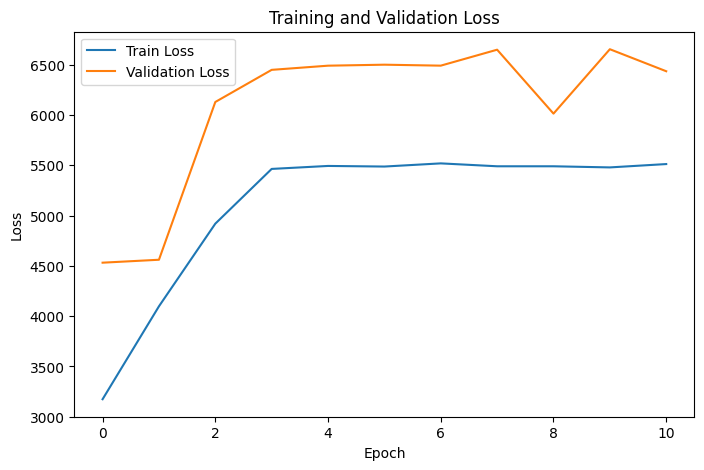

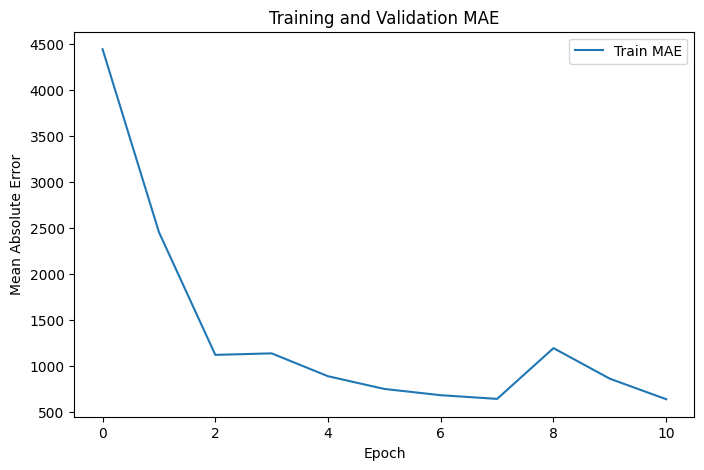

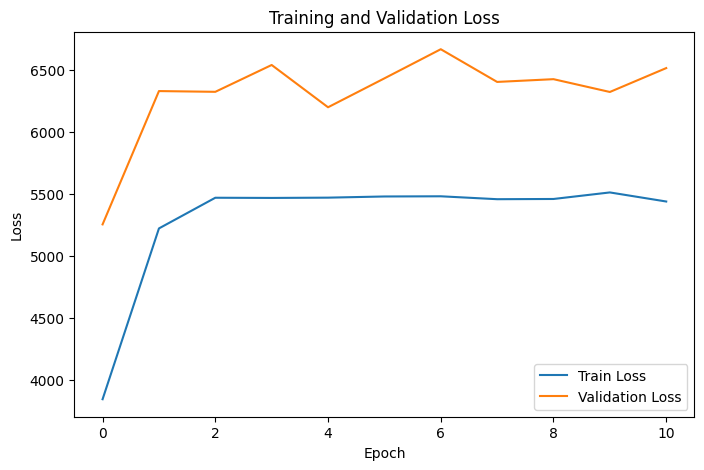

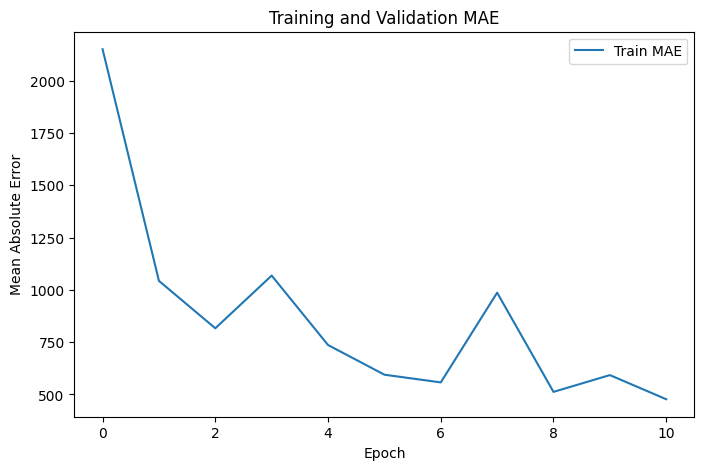

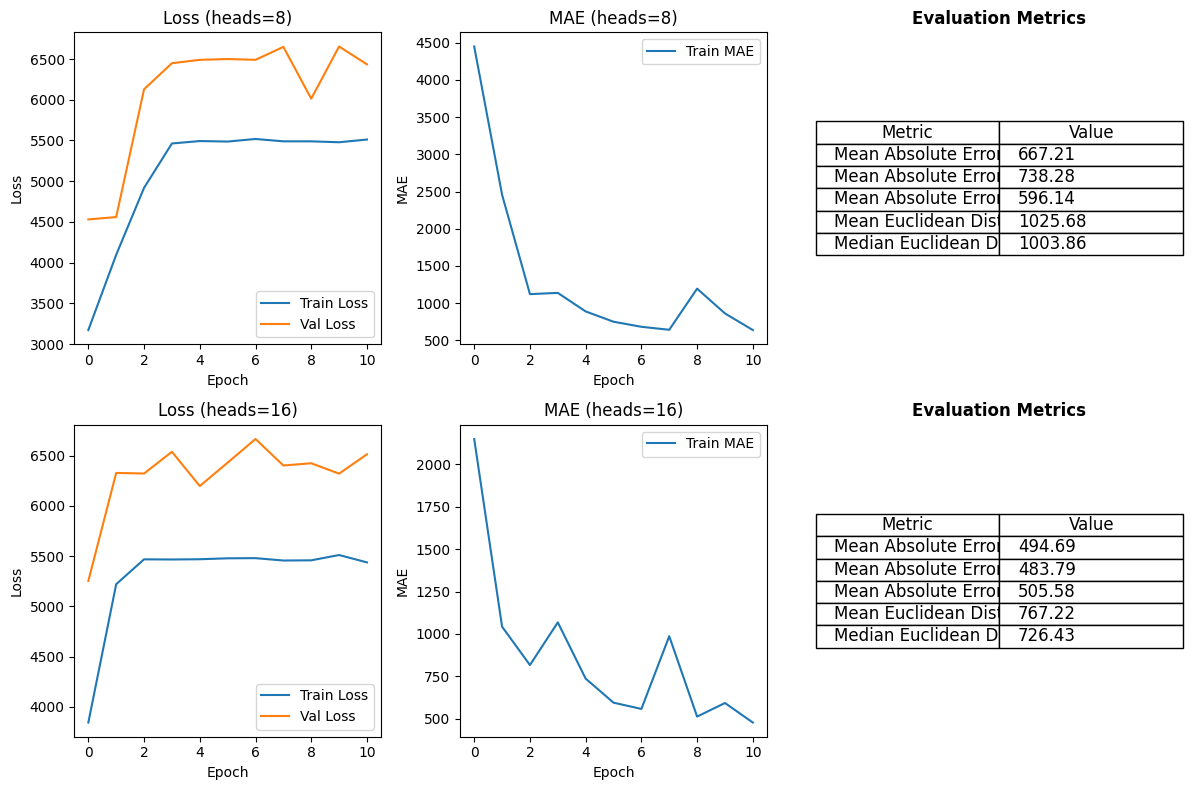

In [ ]:
""" 
Perform hyperparameter tuning of the number of attention heads and try a deeper embedding of the node
features. For the attention heads, just evaluate 2 additional settings. For the embedding of the node features,
instead of the linear transformation of the node states as suggested in the tutorial, try to add one fully connected
layer with ReLU activation and one additional fully connected layer.
"""

import matplotlib.pyplot as plt

NUM_HEADS_LIST = [8, 16]
histories = []
metrics_list = []

for num_heads in NUM_HEADS_LIST:
    # Define hyper-parameters
    HIDDEN_UNITS = 100
    NUM_HEADS = num_heads
    NUM_LAYERS = 3
    OUTPUT_DIM = 2

    NUM_EPOCHS = 100
    LEARNING_RATE = 1e-5

    # Build model
    gat_model = GraphAttentionNetwork(
        HIDDEN_UNITS, NUM_HEADS, NUM_LAYERS, OUTPUT_DIM
    )

    callbacks = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

    # Compile model
    gat_model.compile(
        loss=keras.losses.MeanAbsoluteError(name="mean_absolute_error"),
        optimizer=keras.optimizers.Adam(
            learning_rate=LEARNING_RATE,
            clipnorm=1.0, 
            epsilon=1e-8
        ),
        metrics=[keras.metrics.MeanAbsoluteError(name="mean_absolute_error")]
    )

    history = gat_model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=NUM_EPOCHS,
        verbose=2,
        callbacks=callbacks
    )

    _, test_accuracy = gat_model.evaluate(x=test_dataset, verbose=1)
    print(f"Test Mean Absolute Error: {test_accuracy}")

    all_predictions = []
    all_ground_truth = []
    sample_count = 0

    print("Evaluating model on entire test dataset")

    for features, edges, targets in test_dataset:
        predictions = gat_model((features, edges), training=False)
        
        # Convert to numpy for easier handling
        pred_np = predictions.numpy()
        targets_np = targets.numpy()
        
        # Store predictions
        all_predictions.append(pred_np)
        all_ground_truth.append(targets_np)
        
        sample_count += len(pred_np)

    print(f"Processed {len(all_predictions)} scenes with {sample_count} total nodes")

    # Concatenate all predictions and ground truth values
    all_pred_concat = np.concatenate(all_predictions)
    all_gt_concat = np.concatenate(all_ground_truth)

    # Calculate MAE for x and y coordinates separately
    mae_x = np.mean(np.abs(all_pred_concat[:, 0] - all_gt_concat[:, 0]))
    mae_y = np.mean(np.abs(all_pred_concat[:, 1] - all_gt_concat[:, 1]))

    # Calculate overall MAE
    mae = np.mean(np.abs(all_pred_concat - all_gt_concat))

    # Calculate Euclidean distance for each prediction
    euclidean_distances = np.sqrt(np.sum((all_pred_concat - all_gt_concat)**2, axis=1))
    mean_euclidean = np.mean(euclidean_distances)
    median_euclidean = np.median(euclidean_distances)

    print("\n===== Evaluation Metrics =====")
    print(f"Mean Absolute Error (overall): {mae:.2f}")
    print(f"Mean Absolute Error (x-coordinate): {mae_x:.2f}")
    print(f"Mean Absolute Error (y-coordinate): {mae_y:.2f}")
    print(f"Mean Euclidean Distance: {mean_euclidean:.2f} units")
    print(f"Median Euclidean Distance: {median_euclidean:.2f} units")

    histories.append(history)
    metrics_list.append({
        "num_heads": num_heads,
        "mae": mae,
        "mae_x": mae_x,
        "mae_y": mae_y,
        "mean_euclidean": mean_euclidean,
        "median_euclidean": median_euclidean
    })


    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.savefig(f"plotsTask2/loss_plot_heads{num_heads}_task2.png")
    #plt.show()
    

    plt.figure(figsize=(8, 5))
    plt.plot(history.history['mean_absolute_error'], label='Train MAE')
    if 'val_mean_absolute_error' in history.history:
        plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.title('Training and Validation MAE')
    plt.legend()
    plt.savefig(f"plotsTask2/MAE_plot_heads{num_heads}_task2.png")
    #plt.show()


fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for idx, (history, metrics) in enumerate(zip(histories, metrics_list)):
    row = idx

    # --- Loss plot ---
    ax_loss = axes[row, 0]
    ax_loss.plot(history.history['loss'], label='Train Loss')
    ax_loss.plot(history.history['val_loss'], label='Val Loss')
    ax_loss.set_title(f'Loss (heads={metrics["num_heads"]})')
    ax_loss.set_xlabel('Epoch')
    ax_loss.set_ylabel('Loss')
    ax_loss.legend()

    # --- MAE plot ---
    ax_mae = axes[row, 1]
    ax_mae.plot(history.history['mean_absolute_error'], label='Train MAE')
    if 'val_mean_absolute_error' in history.history:
        ax_mae.plot(history.history['val_mean_absolute_error'], label='Val MAE')
    ax_mae.set_title(f'MAE (heads={metrics["num_heads"]})')
    ax_mae.set_xlabel('Epoch')
    ax_mae.set_ylabel('MAE')
    ax_mae.legend()

    # --- Metrics table ---
    ax_table = axes[row, 2]
    ax_table.axis('off')
    cell_text = [
        ["Mean Absolute Error (overall)", f"{metrics['mae']:.2f}"],
        ["Mean Absolute Error (x)", f"{metrics['mae_x']:.2f}"],
        ["Mean Absolute Error (y)", f"{metrics['mae_y']:.2f}"],
        ["Mean Euclidean Distance", f"{metrics['mean_euclidean']:.2f}"],
        ["Median Euclidean Distance", f"{metrics['median_euclidean']:.2f}"]
    ]
    table = ax_table.table(
        cellText=cell_text,
        colLabels=["Metric", "Value"],
        loc='center',
        cellLoc='left'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.2)
    ax_table.set_title("Evaluation Metrics", fontweight="bold")

plt.tight_layout()
plt.savefig("plotsTask2/all_results_grid_task2.png")
plt.show()

# Task 3 replace attention mechanism with cosine similarity

Epoch 1/100


2025-04-18 16:49:41.564653: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 37s - 393ms/step - mean_absolute_error: 4772.7397 - loss: 4108.2393 - val_loss: 4237.9092
Epoch 2/100


2025-04-18 16:49:45.219380: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-18 16:49:47.381784: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 26ms/step - mean_absolute_error: 2260.1208 - loss: 4077.3218 - val_loss: 5010.3921
Epoch 3/100


2025-04-18 16:49:47.677043: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-18 16:49:49.850288: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 26ms/step - mean_absolute_error: 1219.7487 - loss: 5086.1802 - val_loss: 6040.7764
Epoch 4/100


2025-04-18 16:49:50.140971: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-18 16:49:52.304767: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 26ms/step - mean_absolute_error: 826.0321 - loss: 5414.0903 - val_loss: 6437.6240
Epoch 5/100


2025-04-18 16:49:52.595415: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-18 16:49:54.874881: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 3s - 28ms/step - mean_absolute_error: 829.0630 - loss: 5465.5122 - val_loss: 6272.3335
Epoch 6/100


2025-04-18 16:49:55.188199: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-18 16:49:57.363360: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 26ms/step - mean_absolute_error: 880.8596 - loss: 5492.7808 - val_loss: 6373.8848
Epoch 7/100


2025-04-18 16:49:57.668004: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-18 16:49:59.827422: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 26ms/step - mean_absolute_error: 724.9363 - loss: 5502.4395 - val_loss: 6692.9463
Epoch 8/100


2025-04-18 16:50:00.136426: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-18 16:50:02.313325: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 26ms/step - mean_absolute_error: 633.8819 - loss: 5486.4316 - val_loss: 6479.0142
Epoch 9/100


2025-04-18 16:50:02.619324: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-18 16:50:05.006307: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 3s - 29ms/step - mean_absolute_error: 716.6510 - loss: 5497.4243 - val_loss: 6801.4497
Epoch 10/100


2025-04-18 16:50:05.313498: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-18 16:50:07.579063: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 3s - 27ms/step - mean_absolute_error: 534.2224 - loss: 5452.6240 - val_loss: 6513.2095
Epoch 11/100


2025-04-18 16:50:07.881135: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-18 16:50:10.054272: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 26ms/step - mean_absolute_error: 565.2426 - loss: 5482.4321 - val_loss: 6526.8579
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - mean_absolute_error: 541.8995 - loss: 5133.9268


2025-04-18 16:50:10.357376: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-18 16:50:10.484093: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Test Mean Absolute Error: {'mean_absolute_error': <tf.Tensor: shape=(), dtype=float32, numpy=530.44>}
Evaluating model on entire test dataset


2025-04-18 16:50:14.997436: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Processed 19 scenes with 170 total nodes

===== Evaluation Metrics =====
Mean Absolute Error (overall): 530.44
Mean Absolute Error (x-coordinate): 516.95
Mean Absolute Error (y-coordinate): 543.93
Mean Euclidean Distance: 836.22 units
Median Euclidean Distance: 662.60 units
Epoch 1/100


2025-04-18 16:51:17.757883: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 69s - 738ms/step - mean_absolute_error: 3224.6575 - loss: 3172.6379 - val_loss: 4192.3555
Epoch 2/100


2025-04-18 16:51:24.628955: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-18 16:51:32.890201: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 9s - 95ms/step - mean_absolute_error: 1198.6956 - loss: 4858.9688 - val_loss: 6246.6128
Epoch 3/100


2025-04-18 16:51:33.546412: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-18 16:51:41.846703: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 9s - 96ms/step - mean_absolute_error: 1119.2195 - loss: 5335.2227 - val_loss: 6820.4971
Epoch 4/100


2025-04-18 16:51:42.531665: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-18 16:51:51.018124: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 9s - 97ms/step - mean_absolute_error: 794.8141 - loss: 5420.6587 - val_loss: 6450.4077
Epoch 5/100


2025-04-18 16:51:51.674244: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-18 16:52:00.005583: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 9s - 96ms/step - mean_absolute_error: 771.6842 - loss: 5472.3071 - val_loss: 6472.6855
Epoch 6/100


2025-04-18 16:52:00.663093: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-18 16:52:08.987067: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 9s - 95ms/step - mean_absolute_error: 975.4766 - loss: 5452.3008 - val_loss: 7112.8931
Epoch 7/100


2025-04-18 16:52:09.639332: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-18 16:52:18.082368: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 9s - 97ms/step - mean_absolute_error: 704.8790 - loss: 5521.1162 - val_loss: 6403.1172
Epoch 8/100


2025-04-18 16:52:18.748067: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-18 16:52:27.170108: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 9s - 97ms/step - mean_absolute_error: 610.9152 - loss: 5519.4038 - val_loss: 6540.1309
Epoch 9/100


2025-04-18 16:52:27.825351: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-18 16:52:36.407450: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 9s - 98ms/step - mean_absolute_error: 670.1887 - loss: 5481.4644 - val_loss: 6660.2568
Epoch 10/100


2025-04-18 16:52:37.056293: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-18 16:52:45.399971: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 9s - 96ms/step - mean_absolute_error: 702.5259 - loss: 5512.0688 - val_loss: 6307.3237
Epoch 11/100


2025-04-18 16:52:46.125750: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-18 16:52:56.016317: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 11s - 112ms/step - mean_absolute_error: 562.5434 - loss: 5453.6206 - val_loss: 6832.1465
     13/Unknown 0s 9ms/step - mean_absolute_error: 562.1212 - loss: 5481.8535

2025-04-18 16:52:56.683596: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - mean_absolute_error: 563.1901 - loss: 5401.4189
Test Mean Absolute Error: {'mean_absolute_error': <tf.Tensor: shape=(), dtype=float32, numpy=559.8529>}
Evaluating model on entire test dataset


2025-04-18 16:52:56.907430: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-18 16:53:05.754932: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Processed 19 scenes with 170 total nodes

===== Evaluation Metrics =====
Mean Absolute Error (overall): 559.85
Mean Absolute Error (x-coordinate): 481.10
Mean Absolute Error (y-coordinate): 638.60
Mean Euclidean Distance: 886.53 units
Median Euclidean Distance: 840.31 units


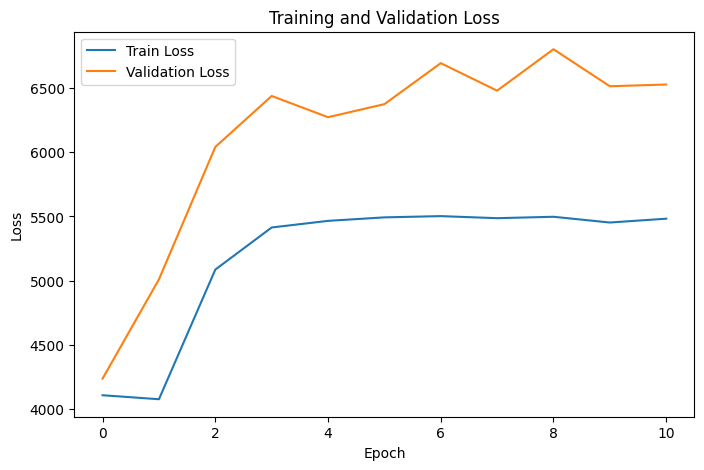

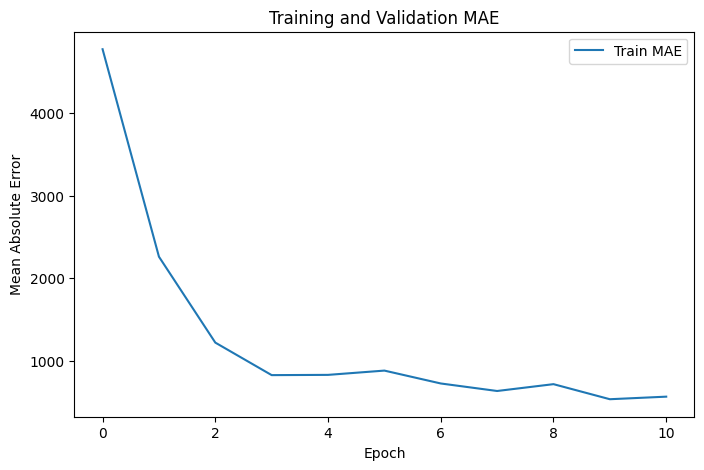

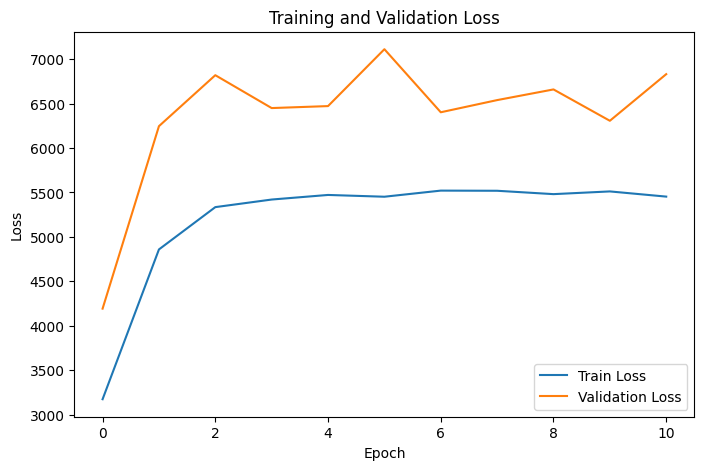

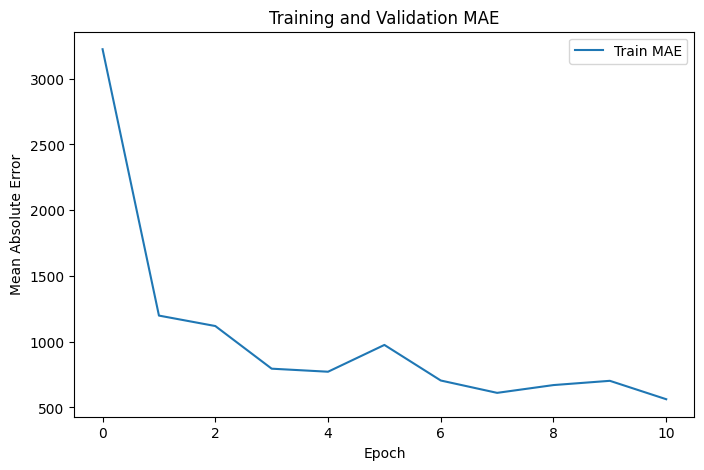

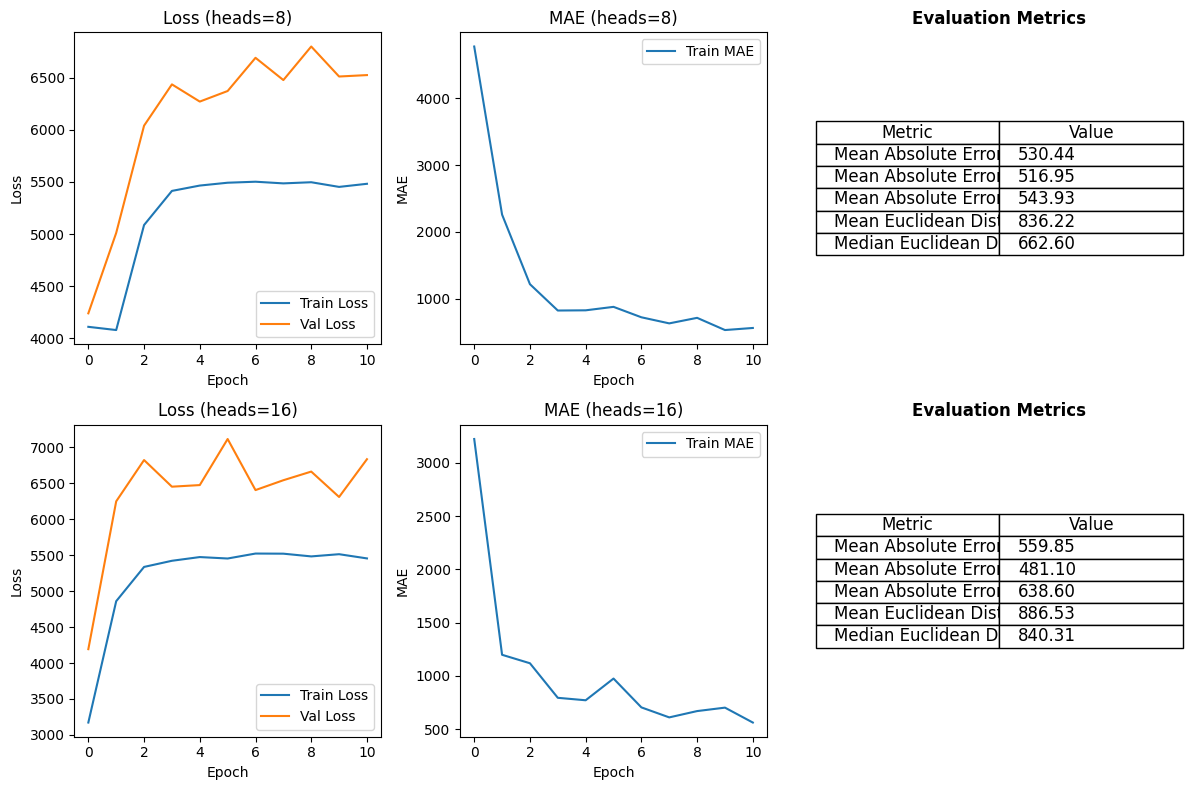

In [ ]:
""" 
Replace the learned attention mechanism with an attention mechanism based on the Cosine similarity between
node vectors.
"""

import matplotlib.pyplot as plt

NUM_HEADS_LIST = [8, 16]
histories = []
metrics_list = []

for num_heads in NUM_HEADS_LIST:
    # Define hyper-parameters
    HIDDEN_UNITS = 100
    NUM_HEADS = num_heads
    NUM_LAYERS = 3
    OUTPUT_DIM = 2

    NUM_EPOCHS = 100
    LEARNING_RATE = 1e-5

    # Build model
    gat_model = GraphAttentionNetwork(
        HIDDEN_UNITS, NUM_HEADS, NUM_LAYERS, OUTPUT_DIM
    )

    callbacks = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

    # Compile model
    gat_model.compile(
        loss=keras.losses.MeanAbsoluteError(name="mean_absolute_error"),
        optimizer=keras.optimizers.Adam(
            learning_rate=LEARNING_RATE,
            clipnorm=1.0, 
            epsilon=1e-8
        ),
        metrics=[keras.metrics.MeanAbsoluteError(name="mean_absolute_error")]
    )

    history = gat_model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=NUM_EPOCHS,
        verbose=2,
        callbacks=callbacks
    )

    _, test_accuracy = gat_model.evaluate(x=test_dataset, verbose=1)
    print(f"Test Mean Absolute Error: {test_accuracy}")

    all_predictions = []
    all_ground_truth = []
    sample_count = 0

    print("Evaluating model on entire test dataset")

    for features, edges, targets in test_dataset:
        predictions = gat_model((features, edges), training=False)
        
        # Convert to numpy for easier handling
        pred_np = predictions.numpy()
        targets_np = targets.numpy()
        
        # Store predictions
        all_predictions.append(pred_np)
        all_ground_truth.append(targets_np)
        
        sample_count += len(pred_np)

    print(f"Processed {len(all_predictions)} scenes with {sample_count} total nodes")

    # Concatenate all predictions and ground truth values
    all_pred_concat = np.concatenate(all_predictions)
    all_gt_concat = np.concatenate(all_ground_truth)

    # Calculate MAE for x and y coordinates separately
    mae_x = np.mean(np.abs(all_pred_concat[:, 0] - all_gt_concat[:, 0]))
    mae_y = np.mean(np.abs(all_pred_concat[:, 1] - all_gt_concat[:, 1]))

    # Calculate overall MAE
    mae = np.mean(np.abs(all_pred_concat - all_gt_concat))

    # Calculate Euclidean distance for each prediction
    euclidean_distances = np.sqrt(np.sum((all_pred_concat - all_gt_concat)**2, axis=1))
    mean_euclidean = np.mean(euclidean_distances)
    median_euclidean = np.median(euclidean_distances)

    print("\n===== Evaluation Metrics =====")
    print(f"Mean Absolute Error (overall): {mae:.2f}")
    print(f"Mean Absolute Error (x-coordinate): {mae_x:.2f}")
    print(f"Mean Absolute Error (y-coordinate): {mae_y:.2f}")
    print(f"Mean Euclidean Distance: {mean_euclidean:.2f} units")
    print(f"Median Euclidean Distance: {median_euclidean:.2f} units")

    histories.append(history)
    metrics_list.append({
        "num_heads": num_heads,
        "mae": mae,
        "mae_x": mae_x,
        "mae_y": mae_y,
        "mean_euclidean": mean_euclidean,
        "median_euclidean": median_euclidean
    })


    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.savefig(f"plotsTask3/loss_plot_heads{num_heads}_task3.png")
    #plt.show()
    

    plt.figure(figsize=(8, 5))
    plt.plot(history.history['mean_absolute_error'], label='Train MAE')
    if 'val_mean_absolute_error' in history.history:
        plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.title('Training and Validation MAE')
    plt.legend()
    plt.savefig(f"plotsTask3/MAE_plot_heads{num_heads}_task3.png")
    #plt.show()


fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for idx, (history, metrics) in enumerate(zip(histories, metrics_list)):
    row = idx

    # --- Loss plot ---
    ax_loss = axes[row, 0]
    ax_loss.plot(history.history['loss'], label='Train Loss')
    ax_loss.plot(history.history['val_loss'], label='Val Loss')
    ax_loss.set_title(f'Loss (heads={metrics["num_heads"]})')
    ax_loss.set_xlabel('Epoch')
    ax_loss.set_ylabel('Loss')
    ax_loss.legend()

    # --- MAE plot ---
    ax_mae = axes[row, 1]
    ax_mae.plot(history.history['mean_absolute_error'], label='Train MAE')
    if 'val_mean_absolute_error' in history.history:
        ax_mae.plot(history.history['val_mean_absolute_error'], label='Val MAE')
    ax_mae.set_title(f'MAE (heads={metrics["num_heads"]})')
    ax_mae.set_xlabel('Epoch')
    ax_mae.set_ylabel('MAE')
    ax_mae.legend()

    # --- Metrics table ---
    ax_table = axes[row, 2]
    ax_table.axis('off')
    cell_text = [
        ["Mean Absolute Error (overall)", f"{metrics['mae']:.2f}"],
        ["Mean Absolute Error (x)", f"{metrics['mae_x']:.2f}"],
        ["Mean Absolute Error (y)", f"{metrics['mae_y']:.2f}"],
        ["Mean Euclidean Distance", f"{metrics['mean_euclidean']:.2f}"],
        ["Median Euclidean Distance", f"{metrics['median_euclidean']:.2f}"]
    ]
    table = ax_table.table(
        cellText=cell_text,
        colLabels=["Metric", "Value"],
        loc='center',
        cellLoc='left'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.2)
    ax_table.set_title("Evaluation Metrics", fontweight="bold")

plt.tight_layout()
plt.savefig("plotsTask3/all_results_grid_task3.png")
plt.show()